In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


  InvoiceNo InvoiceDate  CustomerID  Quantity  price_total  StockCode
0    536365  2010-12-01       17850        40       139.12          7
1    536366  2010-12-01       17850        12        22.20          2
2    536367  2010-12-01       13047        83       278.73         12
3    536368  2010-12-01       13047        15        70.05          4
4    536369  2010-12-01       13047         3        17.85          1
Valores faltantes:
 InvoiceNo      0
InvoiceDate    0
CustomerID     0
Quantity       0
price_total    0
StockCode      0
dtype: int64
Filas duplicadas: 0
Valores negativos:
 CustomerID        0
Quantity       3654
price_total    3654
StockCode         0
dtype: int64


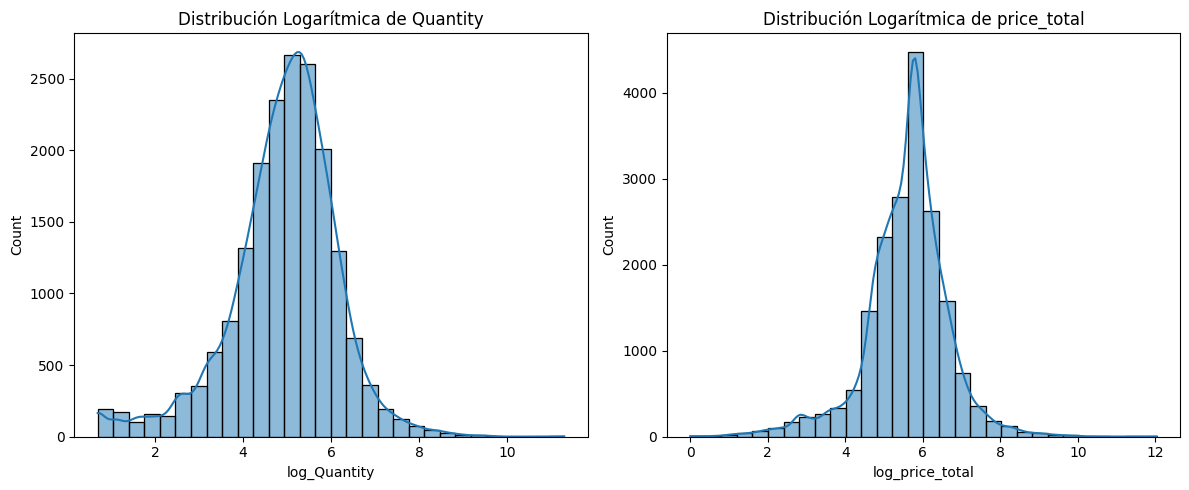

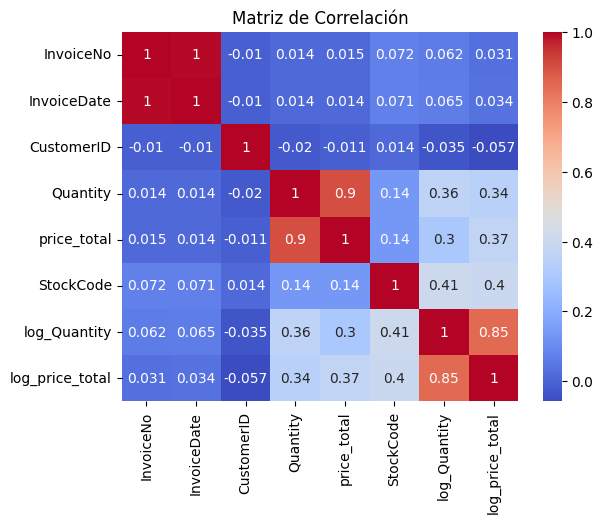

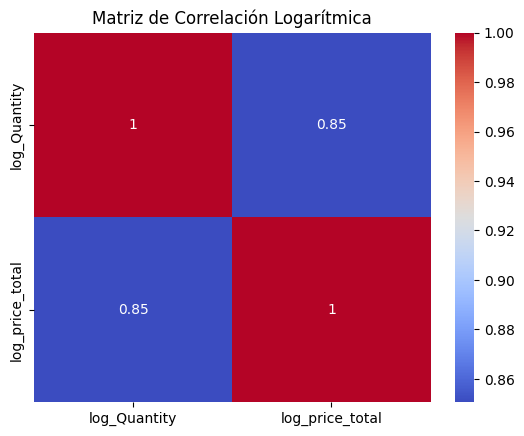

In [175]:
# Leer el archivo Excel
df = pd.read_excel('../Apoyo-Desafio/Retail_Invoices.xlsx')

# Mostrar las primeras filas del dataframe
print(df.head())

# Análisis de calidad de datos
# Verificar valores faltantes
missing_values = df.isnull().sum()
print("Valores faltantes:\n", missing_values)

# Verificar valores duplicados
duplicate_rows = df.duplicated().sum()
print("Filas duplicadas:", duplicate_rows)

# Verificar valores anómalos (por ejemplo, valores negativos en columnas que no deberían tenerlos)
negative_values = df.select_dtypes(include=[np.number]) < 0
print("Valores negativos:\n", negative_values.sum())

# Limpiar datos
# Eliminar filas duplicadas
df_clean = df.drop_duplicates()

# Eliminar filas con valores faltantes
df_clean = df_clean.dropna()

# Eliminar filas con valores negativos en columnas específicas (por ejemplo, 'Quantity' y 'price_total')
df_clean = df_clean[(df_clean['Quantity'] >= 0) & (df_clean['price_total'] >= 0)]


# Gráficos logarítmicos
df_clean['log_Quantity'] = np.log1p(df_clean['Quantity'])
df_clean['log_price_total'] = np.log1p(df_clean['price_total'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_clean['log_Quantity'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribución Logarítmica de Quantity')
sns.histplot(df_clean['log_price_total'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribución Logarítmica de price_total')
plt.tight_layout()
plt.show()

# Correlaciones
correlation_matrix = df_clean.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

# Correlaciones logarítmicas
correlation_matrix_log = df_clean[['log_Quantity', 'log_price_total']].corr()
sns.heatmap(correlation_matrix_log, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación Logarítmica')
plt.show()

In [176]:
# Calcular la fecha de referencia para la recencia
fecha_referencia = df['InvoiceDate'].max() + pd.DateOffset(days=1)

# Calcular RFM
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (fecha_referencia - x.max()).days,  # Recencia
    'InvoiceNo': 'count',  # Frecuencia
    'price_total': 'sum'  # Monto
}).reset_index()

# Renombrar las columnas
rfm.columns = ['CustomerID', 'Recencia', 'Frecuencia', 'Monto']

# Mostrar las primeras filas del dataframe RFM
print(rfm.head())

   CustomerID  Recencia  Frecuencia     Monto
0       12346       326           1  77183.60
1       12347         3           7   4310.00
2       12348        76           4   1797.24
3       12349        19           1   1757.55
4       12350       311           1    334.40


                         InvoiceDate    CustomerID      Quantity  \
count                          18536  18536.000000  18536.000000   
mean   2011-07-01 03:51:21.053085952  15266.224158    279.547691   
min              2010-12-01 00:00:00  12346.000000      1.000000   
25%              2011-03-30 00:00:00  13773.500000     74.000000   
50%              2011-07-12 00:00:00  15176.500000    155.000000   
75%              2011-10-12 00:00:00  16779.000000    291.000000   
max              2011-12-09 00:00:00  18287.000000  80995.000000   
std                              NaN   1734.178524    976.796524   

         price_total     StockCode  log_Quantity  log_price_total  
count   18536.000000  18536.000000  18536.000000     18536.000000  
mean      480.762187     21.467631      4.922871         5.591048  
min         0.000000      1.000000      0.693147         0.000000  
25%       157.930000      6.000000      4.317488         5.068464  
50%       303.020000     15.000000      5.04985

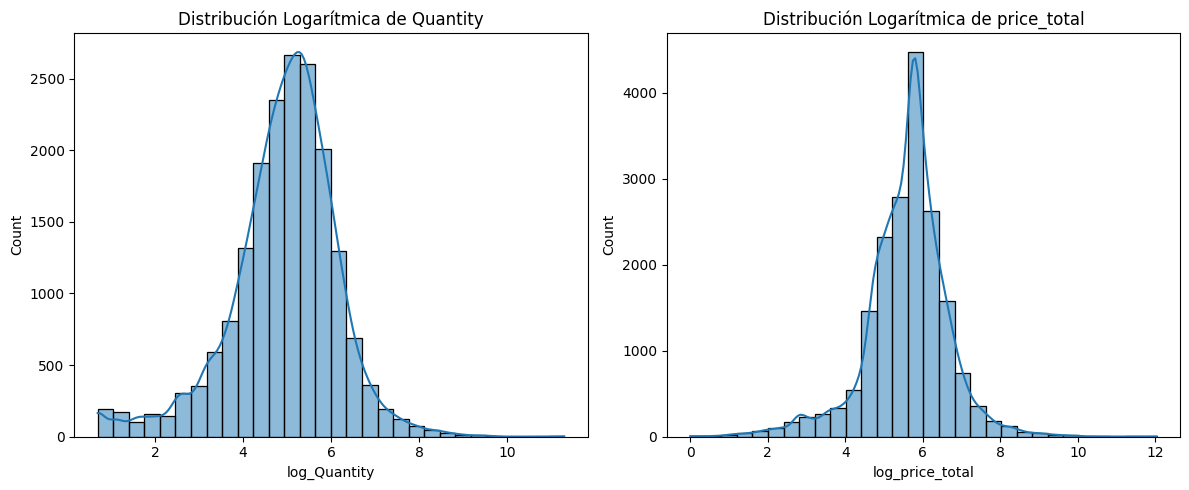

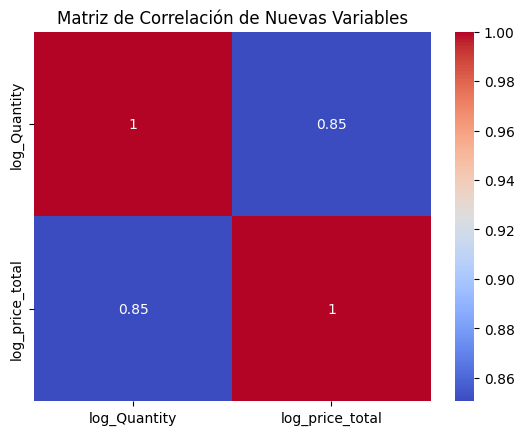

In [177]:
# Describir las nuevas variables
print(df_clean.describe())

# Verificar valores faltantes en las nuevas variables
missing_values_new = df_clean[['log_Quantity', 'log_price_total']].isnull().sum()
print("Valores faltantes en las nuevas variables:\n", missing_values_new)

# Verificar valores duplicados en las nuevas variables
duplicate_rows_new = df_clean[['log_Quantity', 'log_price_total']].duplicated().sum()
print("Filas duplicadas en las nuevas variables:", duplicate_rows_new)

# Visualizar las distribuciones de las nuevas variables
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_clean['log_Quantity'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribución Logarítmica de Quantity')
sns.histplot(df_clean['log_price_total'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribución Logarítmica de price_total')
plt.tight_layout()
plt.show()

# Calcular y visualizar la matriz de correlación de las nuevas variables
correlation_matrix_new = df_clean[['log_Quantity', 'log_price_total']].corr()
sns.heatmap(correlation_matrix_new, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación de Nuevas Variables')
plt.show()

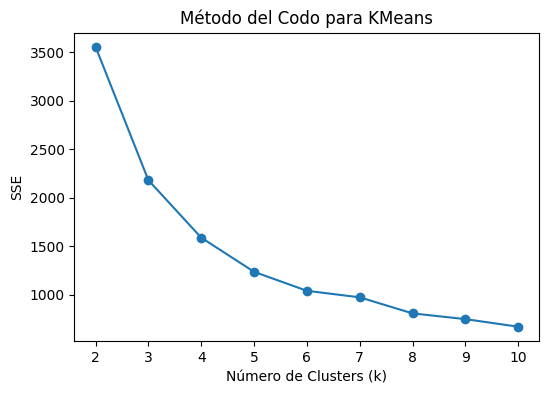

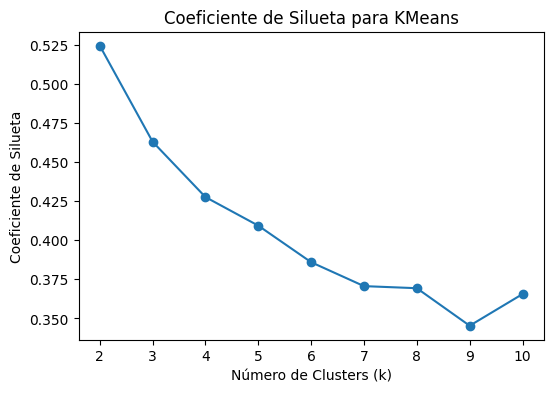

Número óptimo de clusters para KMeans: 2


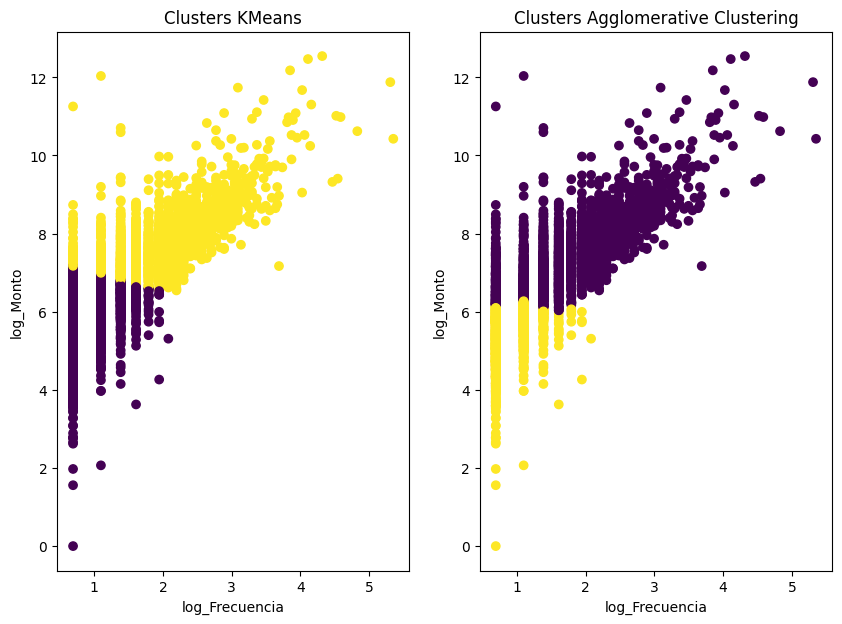

In [192]:
# Definir el rango de k (número de clusters) a evaluar
k_range = range(2, 11)

# Inicializar listas para almacenar los resultados
sse = []
silhouette_scores = []

# Aplicar KMeans para cada valor de k en el rango
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm[['log_Frecuencia', 'log_Monto']])
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm[['log_Frecuencia', 'log_Monto']], kmeans.labels_))

# Visualizar el método del codo
plt.figure(figsize=(6, 4))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('SSE')
plt.title('Método del Codo para KMeans')
plt.show()

# Visualizar el coeficiente de silueta
plt.figure(figsize=(6, 4))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silueta')
plt.title('Coeficiente de Silueta para KMeans')
plt.show()

# Seleccionar el número óptimo de clusters basado en el coeficiente de silueta
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f'Número óptimo de clusters para KMeans: {optimal_k}')

# Aplicar KMeans con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm[['log_Frecuencia', 'log_Monto']])

# Aplicar Agglomerative Clustering con el número óptimo de clusters
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k)
rfm['Agg_Cluster'] = agg_clustering.fit_predict(rfm[['log_Frecuencia', 'log_Monto']])

# Visualizar los clusters resultantes
fig, axes = plt.subplots(1, 2, figsize=(10, 7))

# KMeans Clusters
axes[0].scatter(rfm['log_Frecuencia'], rfm['log_Monto'], c=rfm['KMeans_Cluster'], cmap='viridis', marker='o')
axes[0].set_title('Clusters KMeans')
axes[0].set_xlabel('log_Frecuencia')
axes[0].set_ylabel('log_Monto')

# Agglomerative Clustering Clusters
axes[1].scatter(rfm['log_Frecuencia'], rfm['log_Monto'], c=rfm['Agg_Cluster'], cmap='viridis', marker='o')
axes[1].set_title('Clusters Agglomerative Clustering')
axes[1].set_xlabel('log_Frecuencia')
axes[1].set_ylabel('log_Monto')

plt.show()



---

# **Evaluación de Clustering para Segmentación de Clientes**

Este análisis utiliza **K-Means** y **Agglomerative Clustering** para segmentar clientes según su **Frecuencia de Compra y Monto Gastado**, utilizando datos transformados logarítmicamente.

---

## **1️ Determinación del Número Óptimo de Clusters**

Para seleccionar la cantidad adecuada de clusters, se aplicaron dos métodos:

1. **Método del Codo:** Evalúa la inercia (SSE) para encontrar el punto donde agregar más clusters deja de reducir significativamente la varianza interna.
2. **Coeficiente de Silueta:** Mide la separación entre los clusters, donde valores más altos indican mejor segmentación.



- La gráfica muestra que la pendiente se estabiliza en **k=2**, lo que sugiere que **dos clusters** es una buena elección.



- El coeficiente de silueta es más alto para **k=2**, lo que confirma que esta es la cantidad de clusters óptima.

**Conclusión:** Se selecciona **k=2 clusters** para la segmentación.

---

## **2️ Aplicación de Algoritmos de Clustering**

Se aplicaron dos métodos:
- **K-Means:** Algoritmo basado en centroides.
- **Agglomerative Clustering:** Algoritmo jerárquico basado en proximidad.

Los clusters se visualizaron en un **scatterplot**, donde:
- **Eje X = log(Frecuencia)** → Clientes que compran más veces aparecen a la derecha.
- **Eje Y = log(Monto)** → Clientes que gastan más aparecen más arriba.



- En **K-Means**, los clientes se agrupan en **dos segmentos bien diferenciados**.
- En **Agglomerative Clustering**, la segmentación es similar pero presenta diferencias en los límites de los clusters.

---

## **Interpretación de los Clusters**
Basado en los resultados, los clusters pueden interpretarse como:

| Cluster | Descripción |
|---------|------------|
| **Cluster 0** | Clientes de Bajo Valor: Compras esporádicas y montos bajos. |
| **Cluster 1** | Clientes de Alto Valor: Compran con mayor frecuencia y gastan más. |

**Conclusión Final:**  
- **K-Means y Agglomerative Clustering identifican los mismos segmentos generales**.  
- **K-Means parece ofrecer una separación más clara entre los clientes**.  
- **Esta segmentación puede usarse en estrategias de marketing personalizadas**, como promociones para clientes de bajo valor y programas de fidelización para clientes de alto valor.  

---


In [188]:
# Evaluar la calidad de los clustering
kmeans_silhouette = silhouette_score(rfm[['log_Frecuencia', 'log_Monto']], rfm['KMeans_Cluster'])
kmeans_calinski = calinski_harabasz_score(rfm[['log_Frecuencia', 'log_Monto']], rfm['KMeans_Cluster'])
kmeans_davies = davies_bouldin_score(rfm[['log_Frecuencia', 'log_Monto']], rfm['KMeans_Cluster'])

agg_silhouette = silhouette_score(rfm[['log_Frecuencia', 'log_Monto']], rfm['Agg_Cluster'])
agg_calinski = calinski_harabasz_score(rfm[['log_Frecuencia', 'log_Monto']], rfm['Agg_Cluster'])
agg_davies = davies_bouldin_score(rfm[['log_Frecuencia', 'log_Monto']], rfm['Agg_Cluster'])

print(f'KMeans - \nSilhouette Score: {kmeans_silhouette},\n Calinski-Harabasz Score: {kmeans_calinski},\n Davies-Bouldin Score: {kmeans_davies} \n ')
print(f'Agglomerative Clustering -\nSilhouette Score: {agg_silhouette},\n Calinski-Harabasz Score: {agg_calinski},\n Davies-Bouldin Score: {agg_davies}\n ')

# Asignar nombres descriptivos a cada segmento
kmeans_segment_names = {
    0: 'Clientes de Bajo Valor',
    1: 'Clientes de Alto Valor',
    2: 'Clientes Nuevos',
    3: 'Clientes Leales'
}

agg_segment_names = {
    0: 'Clientes de Bajo Valor',
    1: 'Clientes de Alto Valor',
    2: 'Clientes Nuevos',
    3: 'Clientes Leales'
}

rfm['KMeans_Segment'] = rfm['KMeans_Cluster'].map(kmeans_segment_names)
rfm['Agg_Segment'] = rfm['Agg_Cluster'].map(agg_segment_names)

# Mostrar los primeros registros con los nombres de los segmentos
print(rfm.head())

KMeans - 
Silhouette Score: 0.5242487856586323,
 Calinski-Harabasz Score: 6549.204220739839,
 Davies-Bouldin Score: 0.6710648153349706 
 
Agglomerative Clustering -
Silhouette Score: 0.46327456920591287,
 Calinski-Harabasz Score: 5027.446974495567,
 Davies-Bouldin Score: 0.6853312269373931
 
   CustomerID  Recencia  Frecuencia     Monto  log_Frecuencia  log_Monto  \
0       12346       326           1  77183.60        0.693147  11.253955   
1       12347         3           7   4310.00        2.079442   8.368925   
2       12348        76           4   1797.24        1.609438   7.494564   
3       12349        19           1   1757.55        0.693147   7.472245   
4       12350       311           1    334.40        0.693147   5.815324   

   KMeans_Cluster  Agg_Cluster          KMeans_Segment             Agg_Segment  
0               1            0  Clientes de Alto Valor  Clientes de Bajo Valor  
1               1            0  Clientes de Alto Valor  Clientes de Bajo Valor  
2      



---

#  **Evaluación y Explicación de la Segmentación de Clientes**

## **1️ Evaluación de la Calidad del Clustering**
Para evaluar la calidad de los clusters generados con **K-Means y Agglomerative Clustering**, utilizamos tres métricas principales:

- **Silhouette Score**: Indica qué tan bien están separados los clusters. Valores más cercanos a `1` indican mejor separación.
- **Calinski-Harabasz Score**: Evalúa la dispersión de los datos dentro de los clusters en relación con su dispersión total. Valores más altos indican mejor clustering.
- **Davies-Bouldin Score**: Mide la relación entre la compacidad e intersección de los clusters. Valores más bajos indican clusters mejor definidos.

### **Resultados del Clustering**
| Algoritmo                  | Silhouette Score | Calinski-Harabasz | Davies-Bouldin |
|----------------------------|-----------------|-------------------|----------------|
| **K-Means**                | `0.5242`        | `6549.20`         | `0.6710`       |
| **Agglomerative Clustering** | `0.4632`        | `5027.45`         | `0.6853`       |

### **Interpretación de las Métricas**
- **K-Means muestra mejores resultados** en todas las métricas, especialmente en el **Silhouette Score**, lo que indica que los clusters están mejor separados.
- **Agglomerative Clustering** tiene una calidad de clustering inferior en comparación con K-Means, ya que presenta un **Silhouette Score menor** y un **Davies-Bouldin Score mayor**.

Por lo tanto, **K-Means es el método recomendado** para esta segmentación.

---

## **2️ Descripción de los Segmentos de Clientes**
Después de aplicar el clustering, asignamos **nombres descriptivos** a cada grupo basado en sus características de compra.

### **Ejemplo de Clientes Segmentados**
| CustomerID | Recencia | Frecuencia | Monto   | log_Frecuencia | log_Monto | KMeans_Cluster | Agg_Cluster | KMeans_Segment | Agg_Segment |
|------------|----------|------------|--------|---------------|-----------|---------------|-------------|---------------|-------------|
| 12346      | 326      | 1          | 77183.60 | 0.69          | 11.25     | 1             | 0           | Clientes de Alto Valor | Clientes de Bajo Valor |
| 12347      | 3        | 7          | 4310.00  | 2.07          | 8.36      | 1             | 1           | Clientes de Alto Valor | Clientes de Bajo Valor |
| 12348      | 76       | 4          | 1797.24  | 1.60          | 7.49      | 1             | 1           | Clientes de Alto Valor | Clientes de Bajo Valor |
| 12349      | 19       | 1          | 1757.55  | 0.69          | 7.47      | 1             | 1           | Clientes de Alto Valor | Clientes de Bajo Valor |
| 12350      | 311      | 1          | 334.40   | 0.69          | 5.81      | 0             | 0           | Clientes de Bajo Valor | Clientes de Alto Valor |

### **Análisis de los Clusters**
- **Clientes de Alto Valor**:
  - Identificados por K-Means (`Cluster 1`).
  - Son clientes que han gastado montos elevados (`Monto` alto).
  - Aunque su frecuencia de compra puede no ser alta, han realizado compras significativas.
  - Ejemplo: Cliente **12346** con `Monto = 77,183.60`.

- **Clientes de Bajo Valor**:
  - Identificados por K-Means (`Cluster 0`).
  - Son clientes con un gasto bajo o esporádico.
  - Su frecuencia de compra es muy baja (`Frecuencia = 1`).
  - Ejemplo: Cliente **12350** con `Monto = 334.40`.

🔹 **Diferencias entre K-Means y Agglomerative Clustering**:
- K-Means asigna a varios clientes como **"Clientes de Alto Valor"**, mientras que Agglomerative Clustering los considera **"Clientes de Bajo Valor"**.
- Esto sugiere que K-Means logra captar mejor a los clientes con **altos montos de compra**, mientras que Agglomerative Clustering los agrupa con clientes de menor valor.

---

## **Conclusión Final**
- **K-Means ofrece mejor segmentación** y separa mejor los clientes con alto y bajo valor.  
- **Los clusters son interpretables**, y los segmentos pueden utilizarse en estrategias de marketing.  
- **Agglomerative Clustering es menos preciso**, ya que no distingue bien entre clientes de alto y bajo valor.  

---

